# Applicability of 160MeV gantry systems for proton therapy

A proton energy of 160MV corresponds to a depth in the patient of 18 cm. The purpose of this study is to evaluate the potential of a 160MeV system on a clinical point-of-view.

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We downloaded cancer incidence rates in the US from https://seer.cancer.gov/popdata/download.html. According to the cancer categories in this list, we assign an applicability value for proton therapy based on published results. By no way, this doesn't mean that all cancers of a category will be treated with proton therapy. However, we are interested in the fraction among these cases that is applicable for a reduced range proton therapy. 

In order to determine this, we estimate the depth in an organ in the body, and assign a second category variable telling us if the cancer could be treated with a range of 18cm. The variable takes 3 values: YES (18 cm is enough), MAYBE (no sure about 18cm) and NO (18 cm is not enough, or cancer cannot be treated with PT). We also assign a weight factor to each cancer type to qualitatively characterize the proportion of treatments that use proton therapy. These guesses have been based on https://indico.gsi.de/event/1910/contribution/24/material/slides/0.pdf 

We group all results in a data frame for further analysis.

In [125]:
# import data per sex for all US 
# downlodaded from https://seer.cancer.gov/popdata/download.html 
df_newcases = pd.read_excel (r'D:\clinical\databases\NewCaseEstimates_US.xlsx',sheet_name='All US',skiprows=6) 
df_deaths = pd.read_excel (r'D:\clinical\databases\DeathEstimates_US.xlsx',sheet_name='All US',skiprows=6) 

# change structure to prepare the dataframes for the join
df_newcases.set_index('Cancer Type',inplace=True)
df_newcases.drop(['Both sexes combined'],axis=1,inplace=True) # let's recalculate the sum ourselves
df_newcases.rename(columns={'Male': 'Male new cases','Female': 'Female new cases'}, inplace=True)

df_deaths.set_index('Cancer Type',inplace=True)
df_deaths.drop(['Both sexes combined'],axis=1,inplace=True) # let's recalculate the sum ourselves
df_deaths.rename(columns={'Male': 'Male deaths','Female': 'Female deaths'}, inplace=True)

# join the 2 dataframes
df_all = df_newcases.join(df_deaths)

# cleaning data
df_all.fillna(0,inplace=True)


#########################################
# import table about applicability for PT

df_PT_applicability = pd.read_excel (r'D:\clinical\databases\PT_applicability_vs_cancer_type.xlsx',skiprows=2)
df_PT_applicability.set_index('Cancer type',inplace=True)


# join with the df from the cancer statistics
df_all = df_all.join(df_PT_applicability)

# remove row with all cancer types combined
df_all.drop('All cancer types combined',axis=0,inplace=True)

df_all.head()

,Female new cases,Male new cases,Female deaths,Male deaths,PT applicable?,R=18cm PT applicable?,Weight within PT [0-5]
Cancer Type,,,,,,,
Acute lymphocytic leukemia,2650.0,3280.0,650.0,850.0,NO,NO,0.0
Acute myeloid leukemia,9800.0,11650.0,4630.0,6290.0,NO,NO,0.0
"Anus, anal canal and anorectum",5530.0,2770.0,760.0,520.0,MAYBE,MAYBE,1.0
Bones and joints,1470.0,2030.0,700.0,960.0,YES,MAYBE,1.0
Brain and other nervous system,10410.0,13410.0,7850.0,9910.0,YES,YES,4.0


In [126]:
# delete unclear types containing "Other" (statistically irrelevant and unclear definition)
cancer_types = df_all.index.to_list()
indexes_to_delete = []

for cancer in cancer_types:
    if cancer.find('Other') != -1:
        indexes_to_delete = indexes_to_delete + [cancer]
        
df_all.drop(indexes_to_delete, axis=0, inplace=True)    

Let us group male and female groups and compute the death rate for each cancer.

We sort the cancers by incidence rate.

In [127]:
# Calculate new columns to evaluate the potential of proton therapy at R=18cm

df_all['total deaths'] = df_all['Male deaths'] + df_all['Female deaths']
df_all['total new cases'] = df_all['Male new cases'] + df_all['Female new cases']

df_all['death rate [%]'] = df_all['total deaths']/df_all['total new cases']*100

df_all.sort_values(by=['total new cases'], ascending=False, inplace=True)

# drop initial columns
df_all.drop(['Male deaths', 'Female deaths', 'Male new cases', 'Female new cases'], axis=1, inplace=True)  

# show new dataframe
df_all.head()

,PT applicable?,R=18cm PT applicable?,Weight within PT [0-5],total deaths,total new cases,death rate [%]
Cancer Type,,,,,,
Digestive system,YES,MAYBE,2.0,165460.0,328030.0,50.440508
Genital system,MAYBE,MAYBE,1.0,65540.0,295290.0,22.195130
Breast,YES,YES,2.0,42260.0,271270.0,15.578575
Respiratory system,YES,YES,4.0,147510.0,246440.0,59.856354
Lung and bronchus,YES,YES,5.0,142670.0,228150.0,62.533421


<Figure size 432x432 with 0 Axes>

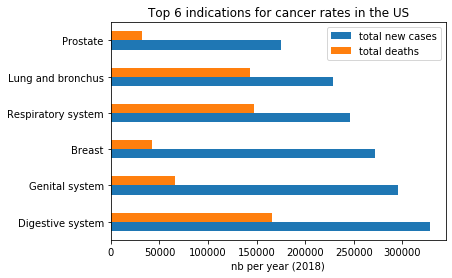

<Figure size 432x432 with 0 Axes>

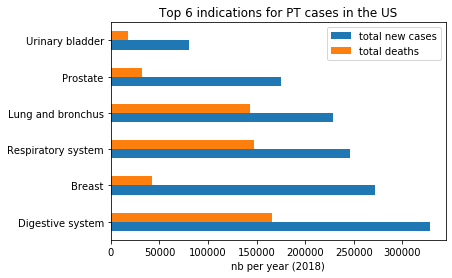

In [128]:
# Plot cancer stats
plt.figure('cancer stats', figsize=(6, 6));
df_all.head(6).plot.barh(y=['total new cases','total deaths']);
plt.title('Top 6 indications for cancer rates in the US');
plt.xlabel('nb per year (2018)');
plt.ylabel('');
plt.show();

# Plot stats for PT
plt.figure('cancer stats PT', figsize=(6, 6));
df_all[df_all['PT applicable?'] == 'YES'].head(6).plot.barh(y=['total new cases','total deaths']);
plt.title('Top 6 indications for PT cases in the US');
plt.xlabel('nb per year (2018)');
plt.ylabel('');
plt.show();

In order to determine the fraction of indications that could be treated with 160MeV, we calculate the total number of cases corresponding to potential proton therapy treatments. Out of these, we calculate those that require for certain ranges lower than 18cm and those that might be applicable below 18cm without certainty.

We see that depending on the case, <b><i> between 65% and 85% of the tumors treated in proton therapy require ranges below 18cm </b></i>.

In [129]:
# Calculate applicability

# calculate fraction of cases that are applicable for R=18cm among all PT cases
df_all['new cases weighted'] = df_all['total new cases']*df_all['Weight within PT [0-5]']


PT_applicable_sum = df_all[df_all['PT applicable?']=='YES']['new cases weighted'].sum()
PT_R18_applicable_sum_min = df_all[(df_all['R=18cm PT applicable?']=='YES') & (df_all['PT applicable?']=='YES')]['new cases weighted'].sum()
print('PT at 160MeV is applicable in min {:.2%} the overall PT cases'.format(PT_R18_applicable_sum_min/PT_applicable_sum))

# calculate fraction of cases that might be applicable for R=18cm among all PT cases
PT_R18_applicable_sum_max = df_all[((df_all['R=18cm PT applicable?']=='YES') | (df_all['R=18cm PT applicable?']=='MAYBE') & (df_all['PT applicable?']=='YES'))]['new cases weighted'].sum()
print('PT at 160MeV is applicable in max {:.2%} the overall PT cases'.format(PT_R18_applicable_sum_max/PT_applicable_sum))


PT at 160MeV is applicable in min 68.83% the overall PT cases
PT at 160MeV is applicable in max 83.70% the overall PT cases


If we display the cancer types as a function of mortality rate and occurrence rate, we can see that the most critical indications (i.e. high incidence and/or high mortality) can benefit from a 160MeV system. The graph can be slightly misleading as the actual picture is much more complex and a sizable share of cancers that appear applicable for PT are actually treated by other methods (surgery, conventional radiation therapy, etc.).

To clarify the view, we also display the share of each indication within the proton therapy market. It can be seen that the most common indications are still applicable with a 160MeV system. One notable exception is prostate cancer, which is treated with 2 side fields at high range to spare the rectum and the bladder. The relative importance of proton therapy for prostate is however decreasing after its superiority to conventional radiation therapy has been debated by doctors and insurers (prostate cancer has a low fatality rate and might not justify the extra cost of protons). Other, more vicious, forms of cancer (lung, brain, liver, etc.) very rarely need protons above 160MeV.

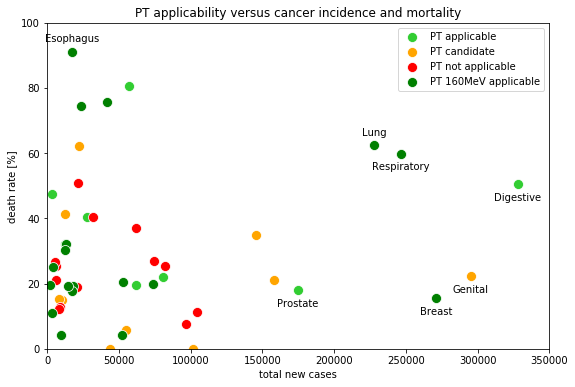

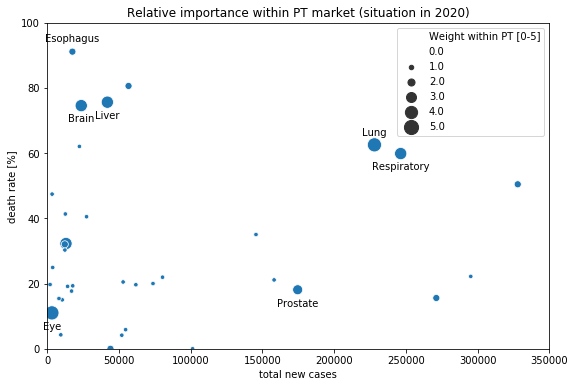

In [130]:
fig = plt.figure(figsize = (9,6))

ax = sns.scatterplot(x='total new cases', y ='death rate [%]', data = df_all[df_all['PT applicable?'] == 'YES'] , 
                     color='limegreen', s = 100)

#ax.legend(loc='upper right', labels=['PT applic'])

ax = sns.scatterplot(x='total new cases', y ='death rate [%]', data = df_all[df_all['PT applicable?'] == 'MAYBE'] , 
                     color='orange', s = 100)


ax = sns.scatterplot(x='total new cases', y ='death rate [%]', data = df_all[df_all['PT applicable?'] == 'NO'] ,  
                     color='red', s = 100)

# overwrite the subcase for R=18cm
ax = sns.scatterplot(x='total new cases', y ='death rate [%]', data = df_all[df_all['R=18cm PT applicable?'] == 'YES'] , 
                     color='green', s = 100)

plt.title('PT applicability versus cancer incidence and mortality')
ax.legend(loc='upper right', labels=['PT applicable','PT candidate','PT not applicable','PT 160MeV applicable']);

ax.set_xlim(0,350000)
ax.set_ylim(0,100)

# identify main indications
x_breast = df_all.loc['Breast', 'total new cases']
y_breast = df_all.loc['Breast', 'death rate [%]']
ax.text(x_breast, y_breast - 5, 'Breast', horizontalalignment='center')

x_breast = df_all.loc['Digestive system', 'total new cases']
y_breast = df_all.loc['Digestive system', 'death rate [%]']
ax.text(x_breast, y_breast - 5, 'Digestive', horizontalalignment='center')

x_breast = df_all.loc['Genital system', 'total new cases']
y_breast = df_all.loc['Genital system', 'death rate [%]']
ax.text(x_breast, y_breast - 5, 'Genital', horizontalalignment='center')

x_breast = df_all.loc['Respiratory system', 'total new cases']
y_breast = df_all.loc['Respiratory system', 'death rate [%]']
ax.text(x_breast, y_breast - 5, 'Respiratory', horizontalalignment='center')

x_breast = df_all.loc['Lung and bronchus', 'total new cases']
y_breast = df_all.loc['Lung and bronchus', 'death rate [%]']
ax.text(x_breast, y_breast + 3, 'Lung', horizontalalignment='center');

x_breast = df_all.loc['Esophagus', 'total new cases']
y_breast = df_all.loc['Esophagus', 'death rate [%]']
ax.text(x_breast, y_breast + 3, 'Esophagus', horizontalalignment='center');

x_breast = df_all.loc['Prostate', 'total new cases']
y_breast = df_all.loc['Prostate', 'death rate [%]']
ax.text(x_breast, y_breast -5, 'Prostate', horizontalalignment='center');



############################################################
# display relative importance to PT market


fig = plt.figure(figsize = (9,6))

ax = sns.scatterplot(x='total new cases', y ='death rate [%]', data = df_all , 
                     size = 'Weight within PT [0-5]', sizes=[0,20,50,100,150,200])


plt.title('Relative importance within PT market (situation in 2020)')
ax.set_xlim(0,350000)
ax.set_ylim(0,100)

# identify main indications
x_breast = df_all.loc['Brain and other nervous system', 'total new cases']
y_breast = df_all.loc['Brain and other nervous system', 'death rate [%]']
ax.text(x_breast, y_breast - 5, 'Brain', horizontalalignment='center')

x_breast = df_all.loc['Liver and intrahepatic bile duct', 'total new cases']
y_breast = df_all.loc['Liver and intrahepatic bile duct', 'death rate [%]']
ax.text(x_breast, y_breast - 5, 'Liver', horizontalalignment='center')

x_breast = df_all.loc['Eye and orbit', 'total new cases']
y_breast = df_all.loc['Eye and orbit', 'death rate [%]']
ax.text(x_breast, y_breast - 5, 'Eye', horizontalalignment='center')

x_breast = df_all.loc['Respiratory system', 'total new cases']
y_breast = df_all.loc['Respiratory system', 'death rate [%]']
ax.text(x_breast, y_breast - 5, 'Respiratory', horizontalalignment='center')

x_breast = df_all.loc['Lung and bronchus', 'total new cases']
y_breast = df_all.loc['Lung and bronchus', 'death rate [%]']
ax.text(x_breast, y_breast + 3, 'Lung', horizontalalignment='center');

x_breast = df_all.loc['Esophagus', 'total new cases']
y_breast = df_all.loc['Esophagus', 'death rate [%]']
ax.text(x_breast, y_breast + 3, 'Esophagus', horizontalalignment='center');

x_breast = df_all.loc['Prostate', 'total new cases']
y_breast = df_all.loc['Prostate', 'death rate [%]']
ax.text(x_breast, y_breast -5, 'Prostate', horizontalalignment='center');


# Conclusion

From this simple analysis, it seems that a limited-energy system could make sense to complement existing multi-room centers, as more than two thirds of the indications (and up to 80%) could be moved to the 160MeV room. It could therefore efficienty extend the customer base of centers that are currently running at full capacity, the those in UFPTI, UPENN or MD Anderson.